# Hate Speech and Offensive Language Detection from Twitter Dataset


In [1]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precisio
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
import string
import re
from collections import Counter
import lime
from lime import lime_tabular
from sklearn.pipeline import make_pipeline
import numpy as np

ImportError: cannot import name 'precisio' from 'sklearn.metrics' (C:\Users\NHC\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Load Dataset and drop unnecessary columns

In [ ]:
df = pd.read_csv("labeled_data.csv")
df=df.drop(df.index[3000:])
df.head()

### Visualization of dataset for output(Imbalanced Dataset)

In [ ]:
flags = ["Hate Speech", "Offensive Language", "Neither"]
values = [df[df["class"] == i].shape[0] for i in range(3)]
plt.bar(flags, values, color="red")
plt.title("Visualization of dataset for output(Imbalanced Dataset)")
print(f"Dataset size: {df.shape}")
plt.show()

### Over sampling for this imbalanced dataset

In [ ]:
ros = RandomOverSampler(random_state=0)
tweet_resampled, class_resampled = ros.fit_resample(np.array(list(df["tweet"])).reshape(-1, 1), list(df["class"]))
tweet_resampled = np.array([tweet[0] for tweet in tweet_resampled])
print(f"Dataset size after oversampling: {len(tweet_resampled)}")

### Visualization of dataset after applying oversampling

In [ ]:
values = [class_resampled.count(i) for i in range(3)]
plt.bar(flags, values, color="yellow")
plt.title("Visualization class distribution for After Applying Oversampling")
plt.show()

### Preprocessing
#### Steps
* Removal of Punctuations
* Lower Casing
* Tokenization
* Removal of Stop Words
* Lemmatization



In [ ]:
# Punctuation Removal

def remove_punctuation(text):
    punctuation_free = "".join([i for i in text if i not in string.punctuation]).strip()
    return punctuation_free

In [ ]:
# Tokenization

def tokenize(text):
    tokens = re.split(r"\s+", text)
    return tokens

In [ ]:
# Remove Stopwords

def remove_stopwords(text):
    removed_stopwords = [i for i in text if i not in stopwords]
    return removed_stopwords

In [ ]:
# Lemmatization

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

In [ ]:
# # Preprocess the resampled text data

tweets_punctuation_free = np.array([remove_punctuation(tweet) for tweet in tweet_resampled])
tweets_lowercase = np.array([tweet.lower() for tweet in tweets_punctuation_free])
tweets_tokenized = np.array([tokenize(tweet) for tweet in tweets_lowercase], dtype=object)
tweets_no_stop_words = np.array([remove_stopwords(tweet) for tweet in tweets_tokenized], dtype=object)
tweets_no_stop_words = np.array([remove_stopwords(tweet) for tweet in tweets_tokenized], dtype=object)
tweets_lemmatized = np.array([lemmatize(tweet) for tweet in tweets_no_stop_words], dtype=object)

### Feature Extraction - Bag of Word using Unigrams

In [ ]:
# Feature Extraction using Count Vectorization

from itertools import count

vectorizer = CountVectorizer()
tweets_lemmatized_str = [" ".join(tweet) for tweet in tweets_lemmatized]
count_vectorized_tweets = vectorizer.fit_transform(tweets_lemmatized_str).toarray()

In [ ]:
# Split the dataset between Train and Test Set

X_train, X_test, y_train, y_test = train_test_split(count_vectorized_tweets, class_resampled, test_size=0.2, random_state=42, shuffle=True)

### Fit the models
Algorithms
* Logistic Regression
* Naive Bayes Classifier
* Kth Nearest Neighbor

### Logistic Regression

In [ ]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
reg_y_predict = reg.predict(X_test)
reg_cf_matrix = confusion_matrix(y_test, reg_y_predict)
reg_train_score = reg.score(X_train, y_train)
reg_test_score = reg.score(X_test, y_test)
print(f"Training accuracy: {reg_train_score}")
print(f"Testing accuracy: {reg_test_score}")

In [ ]:
#LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train, mode="classification", feature_names=vectorizer.get_feature_names_out())

#function to predict with your logistic regression model
predict_fn = lambda x: reg.predict_proba(x)

#An instance to explain
instance_to_explain = X_test[0]

# Get the explanation for the instance
explanation = explainer.explain_instance(instance_to_explain, predict_fn, num_features=len(instance_to_explain))

# Display the results
explanation.show_in_notebook(show_table=True, show_all=False)

### Naive Bayes Classifier

In [3]:
nvc = GaussianNB()
nvc.fit(X_train, y_train)
nvc_y_predict = nvc.predict(X_test)
nvc_cf_matrix = confusion_matrix(y_test, nvc_y_predict)
nvc_train_score = nvc.score(X_train, y_train)
nvc_test_score = nvc.score(X_test, y_test)
print(f"Training accuracy: {nvc_train_score}")
print(f"Testing accuracy: {nvc_test_score}")

NameError: name 'X_train' is not defined

In [4]:
#LIME explainer for Gaussian Naive Bayes
nvc_explainer = lime_tabular.LimeTabularExplainer(X_train, mode="classification", feature_names=vectorizer.get_feature_names_out())

# function to predict with your Gaussian Naive Bayes model
nvc_predict_fn = lambda x: nvc.predict_proba(x)

#An instance to explain
nvc_instance_to_explain = X_test[0]

# Get the explanation for the instance
nvc_explanation = nvc_explainer.explain_instance(nvc_instance_to_explain, nvc_predict_fn, num_features=len(nvc_instance_to_explain))

# Display the results
nvc_explanation.show_in_notebook(show_table=True, show_all=False)


NameError: name 'lime_tabular' is not defined

## Kth Nearest Neighbor

In [5]:
knn = KNN(n_neighbors = 3)
knn.fit(X_train, y_train)
knn_y_predict = knn.predict(X_test)
knn_cf_matrix = confusion_matrix(y_test, knn_y_predict)
knn_train_score = knn.score(X_train, y_train)
knn_test_score = knn.score(X_test, y_test)
print(f"Training accuracy: {knn_train_score}")
print(f"Testing accuracy: {knn_test_score}")

NameError: name 'X_train' is not defined

In [6]:
#LIME explainer for KNN
knn_explainer = lime_tabular.LimeTabularExplainer(X_train, mode="classification", feature_names=vectorizer.get_feature_names_out())

#function to predict with your KNN model
knn_predict_fn = lambda x: knn.predict_proba(x)

#An instance to explain for KNN
knn_instance_to_explain = X_test[0]

# Get the explanation for the instance
knn_explanation = knn_explainer.explain_instance(knn_instance_to_explain, knn_predict_fn, num_features=len(knn_instance_to_explain))

# Display the results
knn_explanation.show_in_notebook(show_table=True, show_all=False)


NameError: name 'lime_tabular' is not defined

### Confusion Matrix, Precision, Recall and F1 Score for Each Model

In [7]:
def display_confusion_matrix(cf_matrix, model_name, color_map):
    dataframe_cfm = pd.DataFrame(cf_matrix, range(3), range(3))
    plt.figure(figsize = (7,5))
    ax = sns.heatmap(dataframe_cfm, annot=True, fmt='', cmap=color_map)
    ax.set_title(f'Confusion Matrix for {model_name} \n\n');
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('Actual Label');
    ax.xaxis.set_ticklabels(['0','1', "2"])
    ax.yaxis.set_ticklabels(['hate_speech','offensive_language', "neither"])
    plt.show()

In [21]:
# Calculate Precision, Recall and F1 Scores

precision_scores = [precision_score(y_test, reg.predict(X_test), average=None), precision_score(y_test, nvc.predict(X_test), average=None), precision_score(y_test, knn.predict(X_test), average=None)]
recall_scores = [recall_score(y_test, reg.predict(X_test), average=None), recall_score(y_test, nvc.predict(X_test), average=None), recall_score(y_test, knn.predict(X_test), average=None)]
f1_scores = [f1_score(y_test, reg.predict(X_test), average=None), f1_score(y_test, nvc.predict(X_test), average=None), f1_score(y_test, knn.predict(X_test), average=None)]

     precision     recall     f1_score
0       0.97       0.97       0.97
1       0.97       0.97       0.97
2       0.97       0.97       0.97


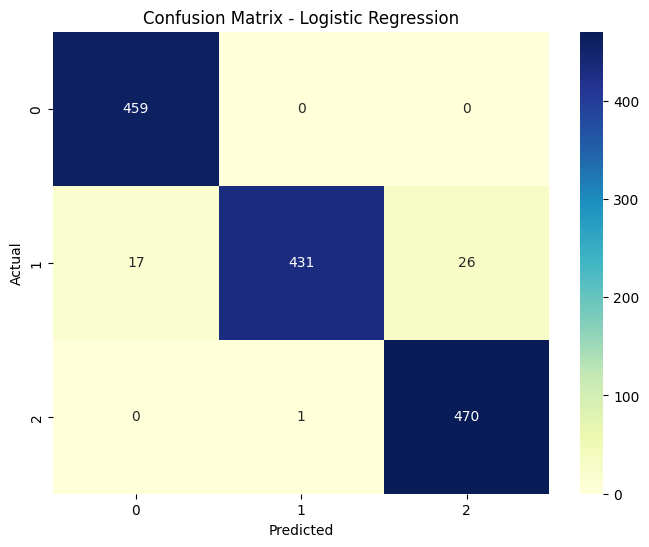

In [22]:
y_pred_reg = reg.predict(X_test)

# Calculate precision, recall, and F1 scores with 'macro' average
precision_reg = precision_score(y_test, y_pred_reg, average='macro')
recall_reg = recall_score(y_test, y_pred_reg, average='macro')
f1_reg = f1_score(y_test, y_pred_reg, average='macro')

# Print precision, recall, and F1 scores
print("     precision     recall     f1_score")
for i in range(3):
    print(f"{i}       {round(precision_reg, 2)}       {round(recall_reg, 2)}       {round(f1_reg, 2)}")

# Display confusion matrix
reg_cf_matrix = confusion_matrix(y_test, y_pred_reg)

# Assuming you have the function display_confusion_matrix
def display_confusion_matrix(cf_matrix, title, cmap):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap=cmap)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display confusion matrix for logistic regression
display_confusion_matrix(reg_cf_matrix, "Logistic Regression", "YlGnBu")


     precision     recall     f1_score
0    0.89           1.0        0.94
1    0.98           0.77        0.86
2    0.89           0.99        0.94


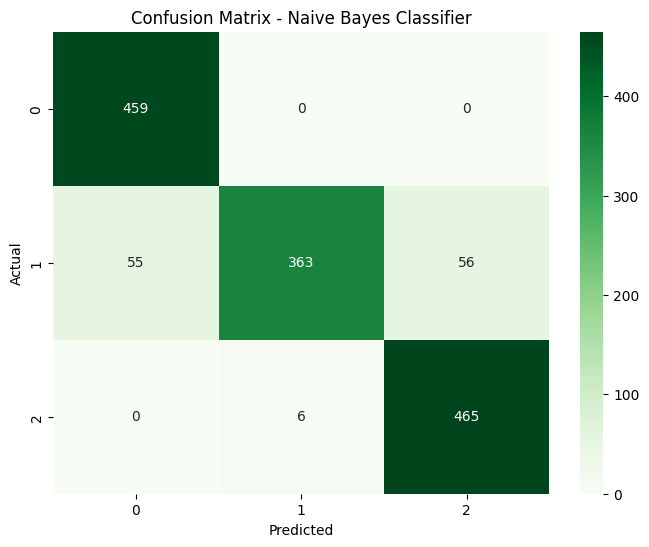

In [23]:
# Confusion Matrix for Naive Bayes Classifier Model

print("     precision     recall     f1_score")
for i in range(3):
    print(f"{i}    {round(precision_scores[1][i], 2)}           {round(recall_scores[1][i], 2)}        {round(f1_scores[1][i], 2)}")

display_confusion_matrix(nvc_cf_matrix, "Naive Bayes Classifier", "Greens")

     precision     recall     f1_score
0    0.93         1.0        0.97
1    0.99         0.81        0.89
2    0.88         0.99        0.93


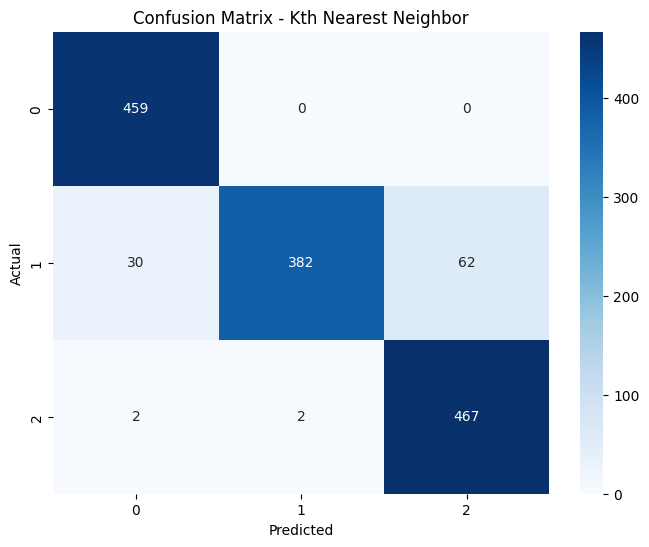

In [24]:
# Confusion Matrix for Kth Nearest Neighbor Model

print("     precision     recall     f1_score")
for i in range(3):
    print(f"{i}    {round(precision_scores[2][i], 2)}         {round(recall_scores[2][i], 2)}        {round(f1_scores[2][i], 2)}" )


display_confusion_matrix(knn_cf_matrix, "Kth Nearest Neighbor", "Blues")

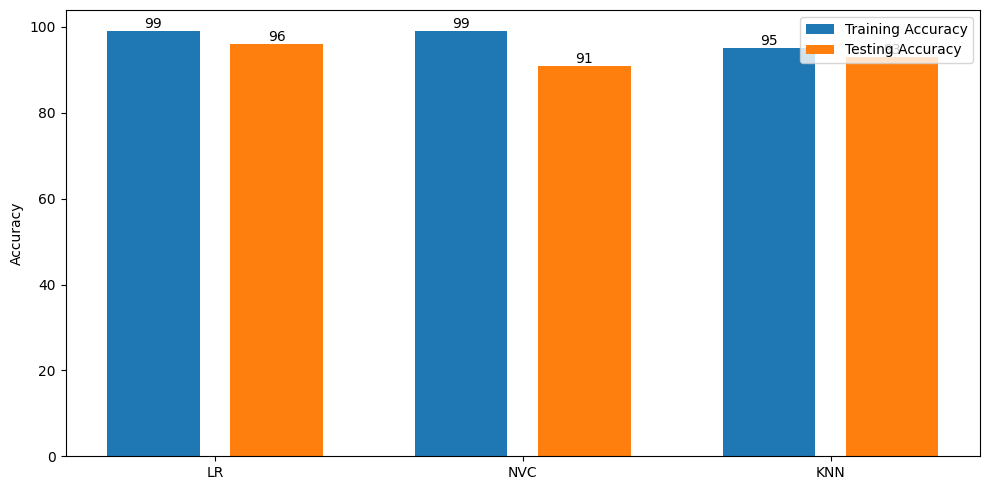

In [25]:
labels = ["LR", "NVC", "KNN"]

train_acc = [reg_train_score*100, nvc_train_score*100, knn_train_score*100]
test_acc = [reg_test_score*100, nvc_test_score*100, knn_test_score*100]

train_acc = np.array(train_acc, dtype=int)
test_acc = np.array(test_acc, dtype=int)

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2 - 0.05, train_acc, width, label="Training Accuracy")
rects2 = ax.bar(x + width/2 + 0.05, test_acc, width, label="Testing Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = "upper right")
ax.bar_label(rects1)
ax.bar_label(rects2)
fig.tight_layout()
plt.show()